# Bragg reflector

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import scipy.constants
import math

from IPython.display import clear_output

import os
import fnmatch
import imageio

## Design of the optical circuit

Design of the geometry of the optical component and set the simulation parameters.

### Solution with different width for the two layers

The condition of constructive interference between the reflected rays of each layer is given by

$n_1 L_1 = \frac{\lambda}{4} \qquad n_2 L_2 = \frac{\lambda}{4}$ &nbsp;&nbsp;&nbsp;&nbsp; or &nbsp;&nbsp;&nbsp;&nbsp; $L (n_1 + n_2) = \frac{\lambda}{2}$

In [2]:
# if plain is True no image will be saved during the simulation
plain = True
# give that plain is False, if animation is True the simulation will produce an .mp4 animation, otherwise it will produce .gif animation
animation = False

     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.745,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.335,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
    

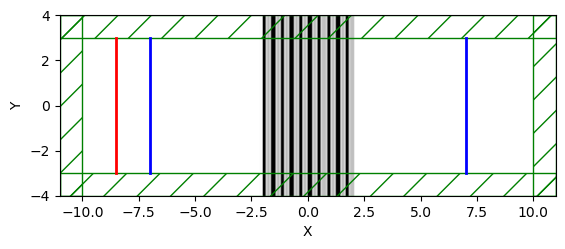

In [3]:
x_dim = 22
y_dim = 8
PML_thick = 1
resolution = 16

n_1 = 1.5 # silica
n_2 = 2.5 # titanium dioxide

layers=10
wavelenght = 1.55

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 1000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    if (not plain):
        f = plt.figure(dpi=600)
        animate = mp.Animate2D(sim, mp.Ez, f=f)
        plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    
    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        if (plain):
            sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_mp4(15, './BraggRifractor.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_gif(15, './BraggRifractor.gif')
    else:
        sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

    clear_output()
    f=plt.figure(dpi=300) #da mettere prima fdel run e poi il show subito dopo il run
    sim.plot2D()
    plt.show()

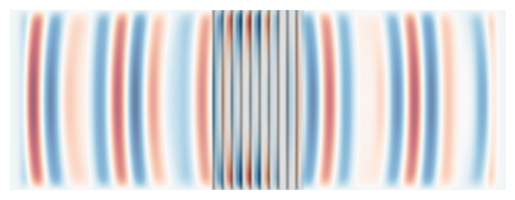

In [4]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

plt.figure()

plt.imshow(np.flipud(np.fliplreps_data.transpose())), interpolation='spline36', cmap='binary')
plt.imshow(np.flipud(np.fliplrez_data.transpose())), interpolation='spline36', cmap='RdBu', alpha=0.6)

plt.axis('off')
plt.show()

Plot the trasmission and reflection due to the DBR.

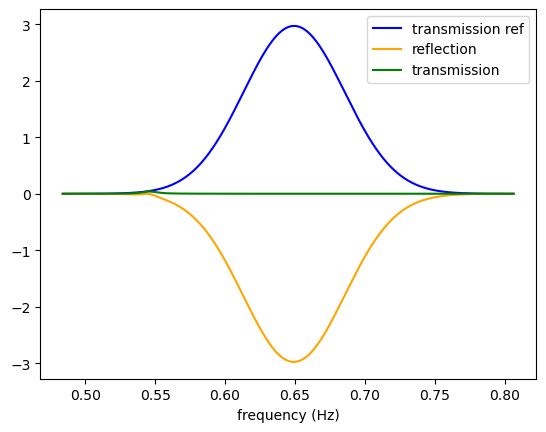

In [6]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

The band width of Ts is 71.63 THz
The minimum of the band of Ts is 0.00019
band center = 198.8839177761633 THz


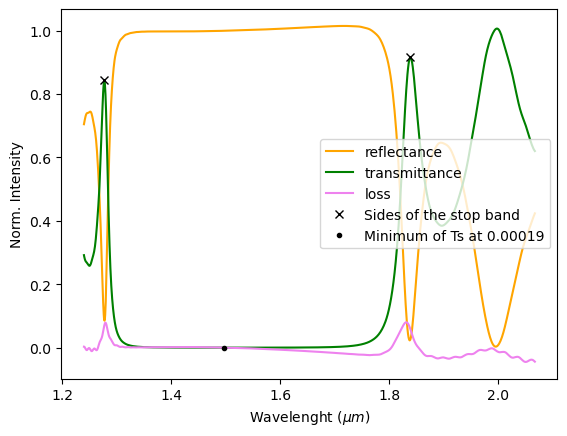

In [7]:
wl = []
Rs = []
Ts = []
Ref = []

for i in range(nfreq):
    wl = np.append(wl, 1/freqs[i])
    Rs = np.append(Rs, -scatt_refl_flux[i]/straight_tran_flux[i]) # il segno è legato all'orientazione del detector
    Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])
    Ref = np.append(Ref, straight_tran_flux[i]/straight_tran_flux[i])

# peak_R, _ = find_peaks(-Rs, prominence=0.5)
peak_T, _ = find_peaks(Ts, prominence=0.5)

peak_T_min, _ = find_peaks(-Ts, prominence=0.8)

plt.plot(wl, Rs, label='reflectance', color='orange')
plt.plot(wl, Ts, label='transmittance', color='green')
# plt.plot(wl, Ref, label='reference', color='blue')
plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')

# for pp in peak_R:
#     plt.plot(wl[pp], Rs[pp], "x", color='red')

plt.plot(wl[peak_T], Ts[peak_T], "x", color='black', label='Sides of the stop band')

for pp in peak_T_min:
    plt.plot(wl[pp], Ts[pp], ".", color='black', label=f'Minimum of Ts at {round(Ts[peak_T_min[0]], 5)}')

# plt.axvline(1/fcen, ls='--', c='r', label=f'th. w.l. = {1/fcen} um')

# dw_R = ( (scipy.constants.c / wl[peak_R[1]]) -  (scipy.constants.c / wl[peak_R[0]]) ) / 10**6
# print(f'The band width of Rs is {round(dw_R, 2)} THz')
# plt.axvline((wl[peak_R[0]] + wl[peak_R[1]])/2, ls='--', c='black', label=f'band center = {round((wl[peak_R[0]] + wl[peak_R[1]])/2, 3)} um \n at Rs = {round(Rs[int((peak_R[0] + peak_R[1])/2)], 3)}')

dw_T = ( (scipy.constants.c / wl[peak_T[1]]) -  (scipy.constants.c / wl[peak_T[0]]) ) / 10**6
print(f'The band width of Ts is {round(dw_T,2)} THz')
print(f'The minimum of the band of Ts is {round(Ts[peak_T_min[0]], 5)}')
w0 = ( (scipy.constants.c / wl[peak_T[1]]) +  (scipy.constants.c / wl[peak_T[0]]) ) / 2 / 10**6
print(f'band center = {w0} THz')

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity')

# plt.yscale("log")

plt.legend(loc='center right')
plt.show()


### Show that the central frequency of the band is efficiently refracted by the DBR

An animation is provided

     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.745,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.335,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
    

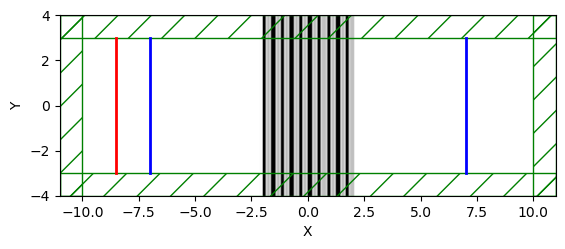

In [8]:
layers=10
wavelenght = 1.55

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 1000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    f = plt.figure(dpi=600)
    animate = mp.Animate2D(sim, mp.Ez, f=f)
    plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        sim.run(mp.at_beginning(mp.output_epsilon),
                mp.at_every(2, animate),
                mp.to_appended('ez', mp.at_every(10, mp.output_efield_z)),
                until=3*x_dim)
        animate.to_mp4(15, './DBRMirror.mp4')
    else:
        sim.run(until=3*x_dim)
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl)
        straight_tran_flux = mp.get_fluxes(tran)

    clear_output()
    sim.plot2D()
    plt.show()

### Solution with same width for all the layers

     block, center = (0,0,0)
          size (3.875,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.84062,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.45312,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.06563,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.678125,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.290625,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon dia

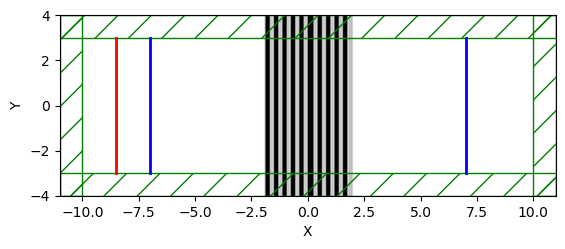

In [9]:
wavelenght = 1.55
grat_period = round(wavelenght / 2 / (n_1 + n_2), 5)
grat_height = y_dim
print(f'\n\nThe period of the grating for a wavelenght of {wavelenght} nm is {grat_period} um\n\n')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 5000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3(grat_period*layers*2, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period, grat_height, 0),
                            center= mp.Vector3((2*ii+0.5)*grat_period, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0), # sempre meglio non mettere le sorgenti sulle interfacce
                                # interfaccia sx + PML + margine
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )
    
    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )


    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
    else:
        sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

    # extraction of fluxes 
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

    clear_output()
    sim.plot2D()
    plt.show()

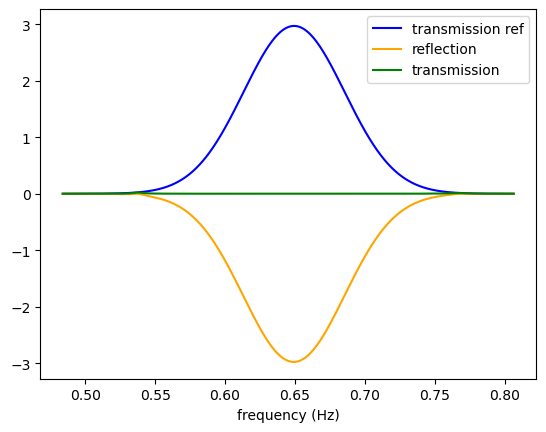

In [10]:
freqs = mp.get_flux_freqs(refl)    

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

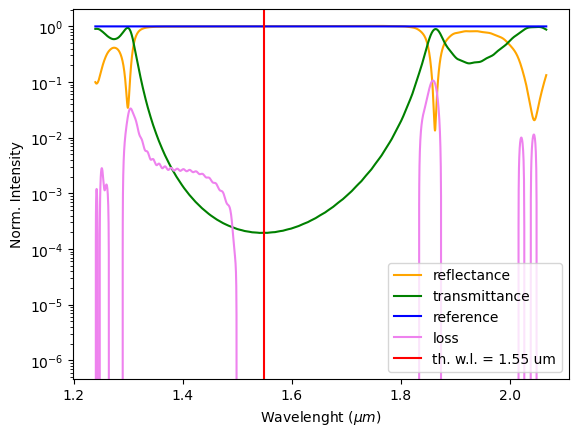

In [11]:
wl = []
Rs = []
Ts = []
Ref = []

for i in range(nfreq):
    wl = np.append(wl, 1/freqs[i])
    Rs = np.append(Rs, -scatt_refl_flux[i]/straight_tran_flux[i]) # il segno è legato all'orientazione del detector
    Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])
    Ref = np.append(Ref, straight_tran_flux[i]/straight_tran_flux[i])

plt.plot(wl, Rs, label='reflectance', color='orange')
plt.plot(wl, Ts, label='transmittance', color='green')
plt.plot(wl, Ref, label='reference', color='blue')
# plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')

plt.axvline(1/fcen, c='r', label=f'th. w.l. = {1/fcen} um')

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity')

plt.yscale("log")


plt.legend(loc='best')
plt.show()

## Dependence of the stop band from the refractive indexes contrast

-----------
Initializing structure...
time for choose_chunkdivision = 0.000443935 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
time for set_epsilon = 0.121664 s
-----------
field decay(t = 50.03125): 0.4517159724781503 / 0.4517159724781503 = 1.0
field decay(t = 100.0625): 2.674280376607529e-12 / 0.4517159724781503 = 5.920269681712185e-12
run 0 finished at t = 100.0625 (3202 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.22 um for the n = 1.8 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000427008 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.8,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.29,0,0)
          size (0.22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
    

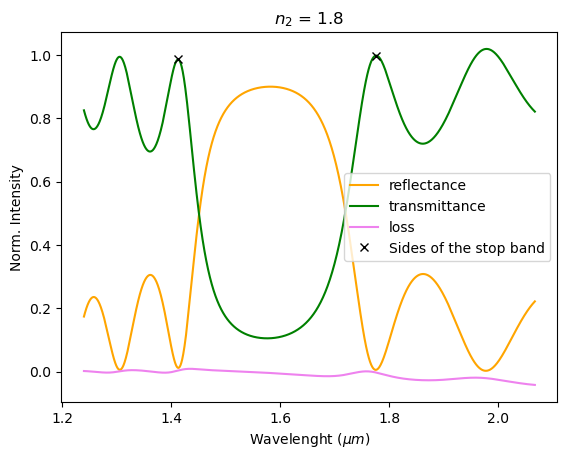

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.2 um for the n = 1.9000000000000001 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000422001 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.6,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.2,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-1.74,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-1.28,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center 

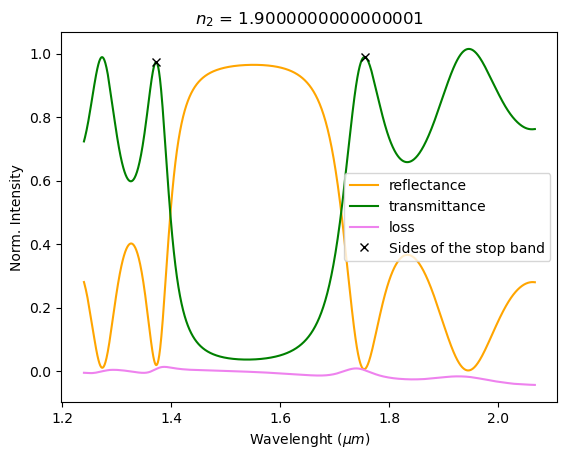

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.19 um for the n = 2.0 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000427008 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.5,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.155,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-1.705,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-1.255,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-0.805,0,0)
          size (0.1

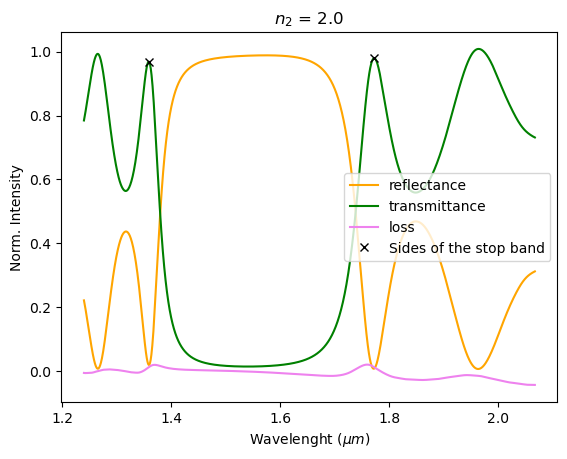

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.1000000000000005 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.00050807 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.11,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, center = (-1.67,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, center = (-1.23,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, cen

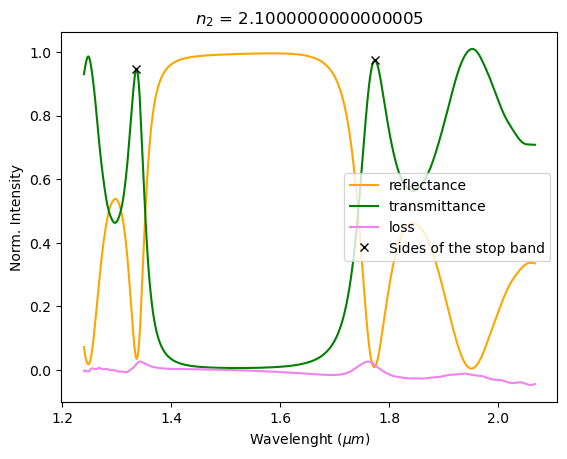

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.2 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000423908 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.11,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-1.67,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-1.23,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-0.79,0

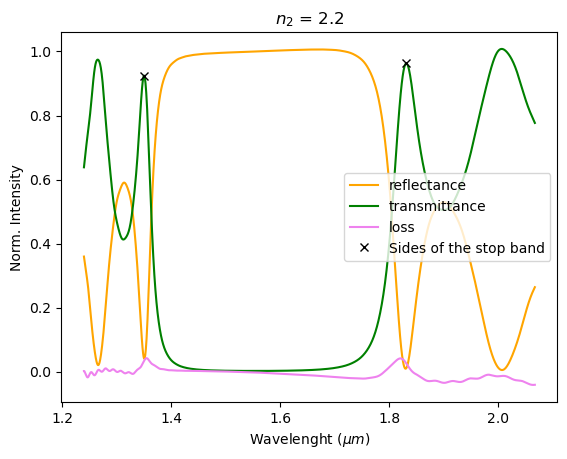

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.17 um for the n = 2.3000000000000007 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000414133 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.3,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.065,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block, center = (-1.635,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block, center = (-1.205,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block,

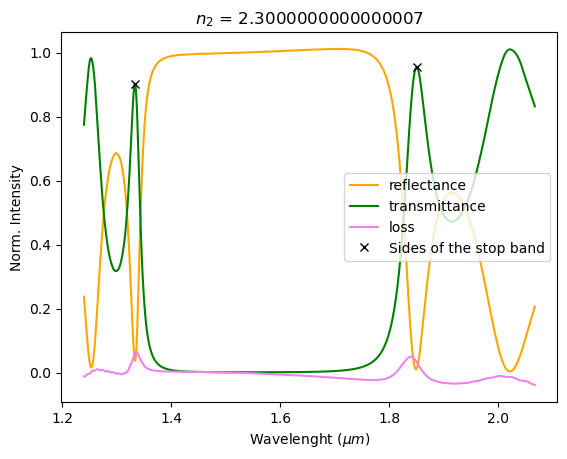

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.16 um for the n = 2.4000000000000004 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000424147 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.02,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-1.6,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-1.18,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, cen

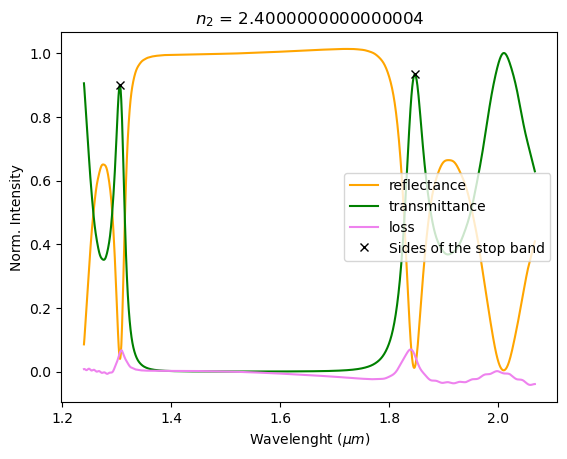

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.500000000000001 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000431061 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, 

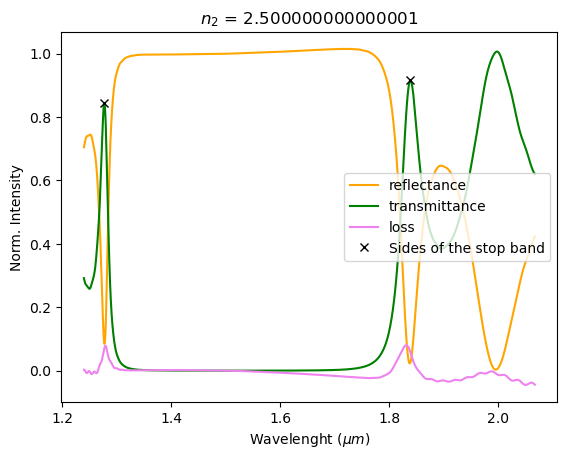

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.6000000000000005 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000414848 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block,

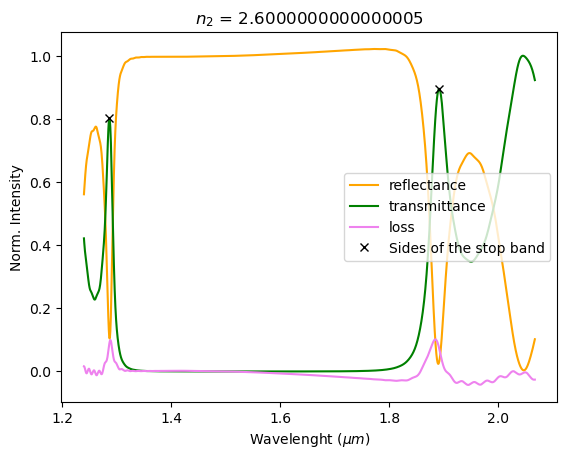

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.700000000000001 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000422955 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.93,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, center = (-1.53,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, center = (-1.13,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, cente

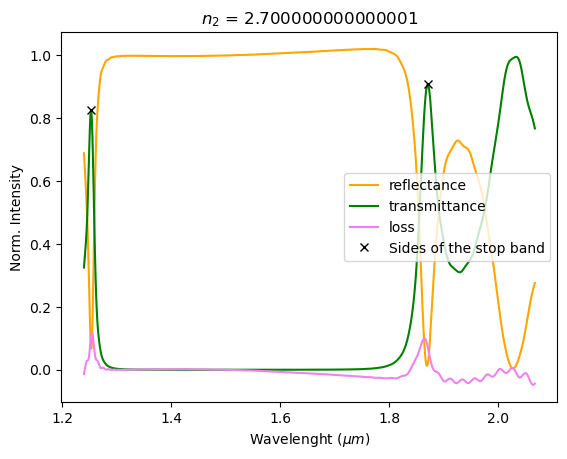

In [12]:
ref_index = []
band_width = []
attenuation = []

plot=True

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

for ind in np.arange(1.8, 2.8, 0.1):
    grat_period_1 = round(wavelenght / 4 / n_1, 2)
    grat_period_2 = round(wavelenght / 4 / ind, 2)
    
    print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
            {grat_period_1} um for the n = {n_1} material
            {grat_period_2} um for the n = {ind} material\n''')

    sim.reset_meep()
    geometry = [mp.Block(
                    mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                    center = mp.Vector3(0,0,0),
                    material = mp.Medium(index=n_1)),
                ]
    for ii in range(-int(layers/2), int(layers/2)):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                        material = mp.Medium(index=ind))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # sim.plot2D()
    # plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
    
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    freqs = mp.get_flux_freqs(refl)    

    wl = []
    Rs = []
    Ts = []

    for i in range(nfreq):
        wl = np.append(wl, 1/freqs[i])
        Rs = np.append(Rs, -scatt_refl_flux[i]/straight_tran_flux[i])
        Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])

    peak_T, _ = find_peaks(Ts, prominence=(0.27 if ind < 2 else 0.4))
    peak_T_min, _ = find_peaks(-Ts, prominence=0.8)

    if (plot):
        plt.plot(wl, Rs, label='reflectance', color='orange')
        plt.plot(wl, Ts, label='transmittance', color='green')
        plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')
        plt.plot(wl[peak_T], Ts[peak_T], "x", color='black', label='Sides of the stop band')

        plt.xlabel('Wavelenght ($\mu m$)')
        plt.ylabel('Norm. Intensity')

        plt.title(f'$n_2$ = {ind}')
        # plt.yscale("log")
        plt.legend(loc='center right')
        plt.show()


    dw_T = ( (scipy.constants.c / wl[peak_T[1]]) -  (scipy.constants.c / wl[peak_T[0]]) ) / 10**6 # THz
    T_min = Ts[peak_T_min[0]]
    
    # print(f'The band width of Ts is {round(dw_T,2)} THz')
    # print(f'The minimum of the band of Ts is {round(T_min, 5)}')

    ref_index += [ind]
    band_width += [dw_T]
    attenuation += [T_min]

The gap width is given by

$\Delta \omega = \omega_0 \frac{4}{\pi} \arcsin{\left | \frac{n_2 - n_1}{n_2 + n_1} \right |}$

In [13]:
def fit_arcsin(x, w0, c):
    return w0 * 4 / math.pi * np.arcsin(x) + c

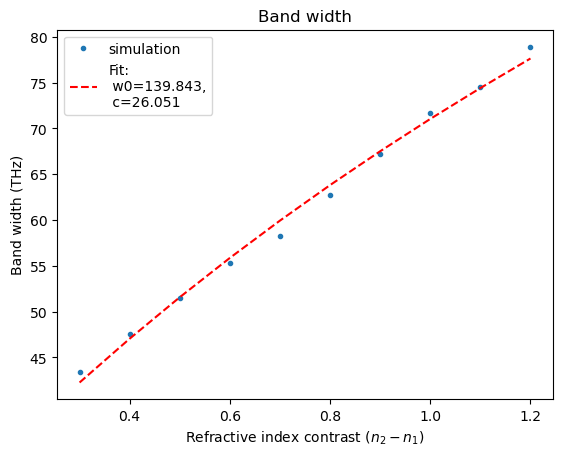

In [14]:
contrast = [ind - n_1 for ind in ref_index]
argument = [(ind - n_1)/(ind + n_1) for ind in ref_index]

popt, _ = curve_fit(fit_arcsin, argument, band_width, p0=[200,0])

fig, ax = plt.subplots(1, 1)
ax.plot(contrast, band_width, '.', label='simulation')
fit_band_width = [fit_arcsin(aa, *popt) for aa in argument]
ax.plot(contrast, fit_band_width, 'r--', label='Fit:\n - w0=%5.3f,\n - c=%5.3f' % tuple(popt))

ax.set_title('Band width')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Band width (THz)')

plt.legend()
plt.show()

The attenuated transmission is given by

$T(\omega_0) \approx 4 \left ( \frac{n_1}{n_2} \right )^{2N}$

In [15]:
def fit_attenuation(x, N):
    return 4 * (n_1 / x)**(2*N)

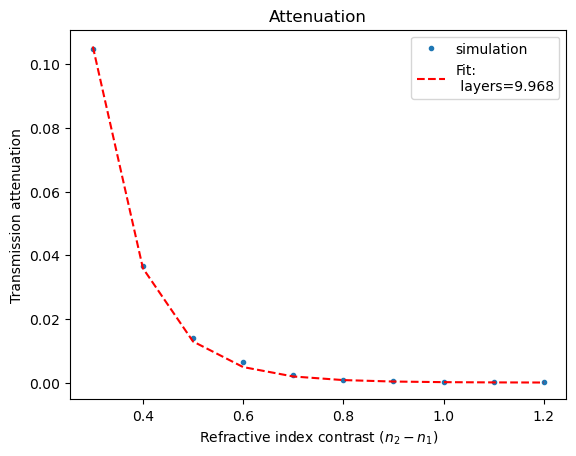

In [16]:
popt, _ = curve_fit(fit_attenuation, ref_index, attenuation, p0=10)

fig, ax = plt.subplots(1, 1)
ax.plot([ind - n_1 for ind in ref_index], attenuation, '.', label='simulation')

fit_att = [fit_attenuation(ind, *popt) for ind in ref_index]
ax.plot(contrast, fit_att, 'r--', label='Fit:\n - layers=%5.3f' % tuple(popt))

ax.set_title('Attenuation')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Transmission attenuation')

plt.legend()
plt.show()

## Use the DBR to construct a cavity

In [17]:
plain = True
animation = True

The period of the grating for a wavelenght of 1.55 nm are:
        0.26 um for the n = 1.5 material
        0.15 um for the n = 2.5 material



/home/elife/anaconda3/envs/meep/lib/python3.11/site-packages/meep/visualization.py:1402: UserWarning: Warning: The 'sim' argument in Animate2D is deprecated and has no effect. It will be removed in a future release.
  warnings.warn(


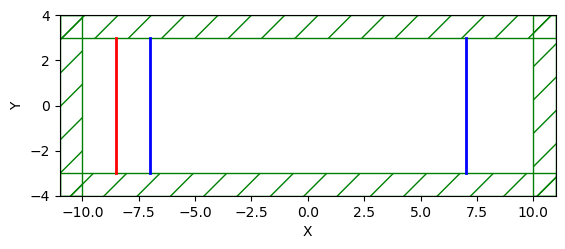

-----------
Initializing structure...
time for choose_chunkdivision = 0.000368834 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.151166 s
-----------
field decay(t = 50.025000000000006): 0.44974309659639516 / 0.44974309659639516 = 1.0
on time step 2750 (time=68.75), 0.00145654 s/step
field decay(t = 100.05000000000001): 4.599436674321694e-13 / 0.44974309659639516 = 1.0226808836266104e-12
run 0 finished at t = 100.05000000000001 (4002 timesteps)
Beginning of n_1 is at -11.0
End of n_1 is at 11.0
Beginning of -7-th n_2 is at -3.3600000000000003
Beginning of -6-th n_2 is at -2.95
Beginning of -5-th n_2 is at -2.54
Beginning of -4-th n_2 is at -2.13
Beginning of -3-th n_2 is at -1.72
Beginning of -2-th n_2 is at -1.3099999999999998
Beginning of -1-th n_2 is at -0.8999999999999999
Beginning of 0-th n_2 is at 0.75
Beginning of 1-th n_2 is at 1.1600000000000001
Beginning of 2-th n_2 is at 1.57
Beginning of 3-th n_2 is at 1.98
Beginning

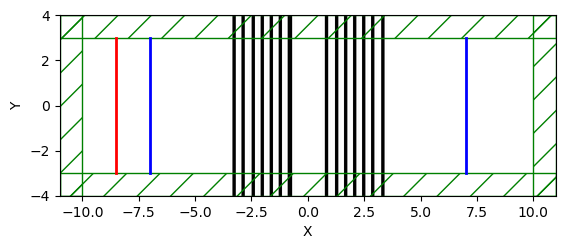

-----------
Initializing structure...
time for choose_chunkdivision = 0.000540972 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.055,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block

In [18]:
x_dim = 22
y_dim = 8
PML_thick = 1
resolution = 20

n_1 = 1.5
n_2 = 2.5

layers=14
wavelenght = 1.55
cavity_width = 1.5

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 5000

sim.reset_meep()
cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        # mp.Vector3(DBL_width, grat_height,0),
                        mp.Vector3(x_dim, y_dim, 0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        print(f'Beginning of n_1 is at {- geometry[0].size.x / 2}')
        print(f'End of n_1 is at {geometry[0].size.x / 2}')
        for ii in range(-int(layers/2), 0):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                            center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                            material = mp.Medium(index=n_2))]
            print(f'Beginning of {ii}-th n_2 is at {geometry[-1].center.x - geometry[-1].size.x / 2}')
        for ii in range(0, int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]
            print(f'Beginning of {ii}-th n_2 is at {(ii)*(grat_period_1+grat_period_2) + cavity_width/2}')

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    if (not plain):
        f = plt.figure(dpi=600)
        animate = mp.Animate2D(sim, mp.Ez, f=f)
        plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )
    
    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.plot2D()
    plt.show()

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        if (plain):
            sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_mp4(15, './DBRCavity.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_gif(15, './DBRCavity.gif')
    else:
        sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

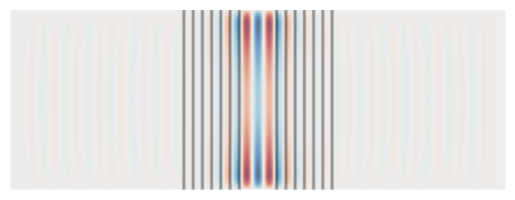

In [19]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

plt.figure()

plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.6)

plt.axis('off')
plt.show()

Plot the trasmission and reflection due to the DBR.

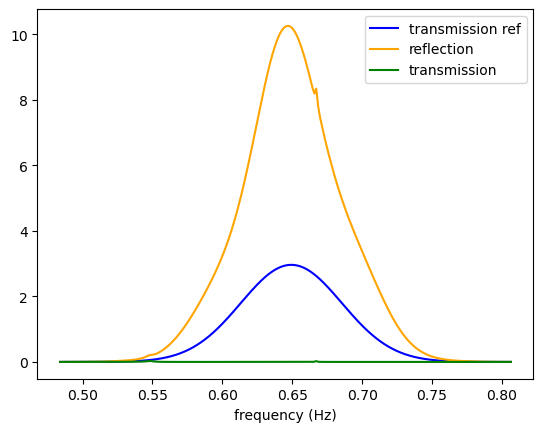

In [21]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

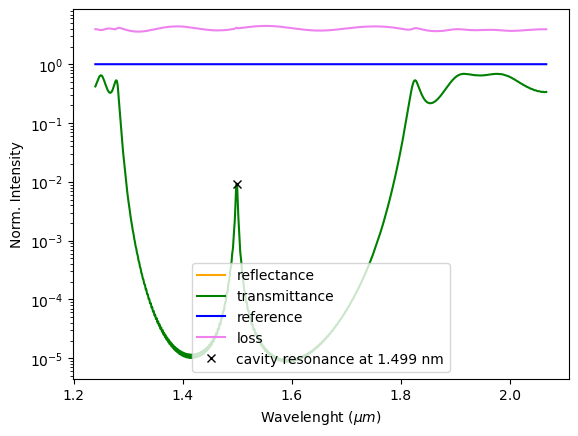

In [22]:
wl = []
Rs = []
Ts = []
Ref = []

for i in range(nfreq):
    wl = np.append(wl, 1/freqs[i])
    Rs = np.append(Rs, -scatt_refl_flux[i]/straight_tran_flux[i]) # il segno è legato all'orientazione del detector
    Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])
    Ref = np.append(Ref, straight_tran_flux[i]/straight_tran_flux[i])

peak_T, _ = find_peaks(Ts, prominence=[0.008, 0.01])

plt.plot(wl, Rs, label='reflectance', color='orange')
plt.plot(wl, Ts, label='transmittance', color='green')
plt.plot(wl, Ref, label='reference', color='blue')
plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')

plt.plot(wl[peak_T], Ts[peak_T], 'x', c='black', label=f'cavity resonance at {round(wl[peak_T[0]],3)} nm')
# plt.axvline(1/fcen, c='r', label=f'th. w.l. = {1/fcen} um')

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity')

plt.yscale("log")

plt.legend(loc='lower center')
plt.show()

Find the Q factor of the cavity

In [23]:
def fit_lorentzian (xx, A, gamma, x0, c):
    return  A/math.pi * gamma/2 / ((xx - x0)**2 + (gamma/2)**2) + c

In [24]:
wl_low = wl[np.where(wl>=1.4)[0]]
wl_cut = wl_low[np.where(wl_low <= 1.6)[0]]

Ts_low = Ts[np.where(wl>=1.4)[0]]
Ts_cut = Ts_low[np.where(wl_low <= 1.6)[0]]


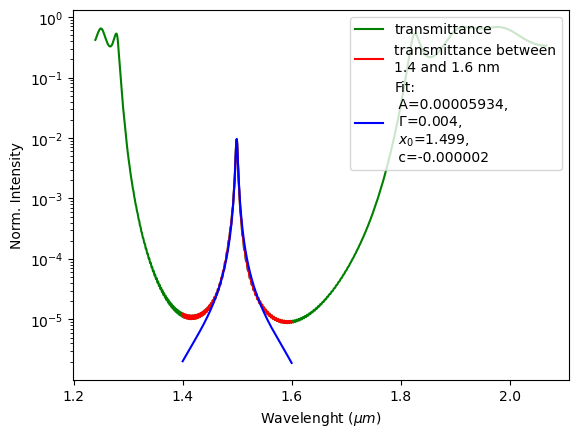

The Q-factor of the cavity is 383.70010095759864


In [25]:
popt, _ = curve_fit(fit_lorentzian, wl_cut, Ts_cut, p0=[0.01, 0.1, wl[peak_T[0]], 0])

plt.plot(wl, Ts, label='transmittance', color='green')
plt.plot(wl_cut, Ts_cut, label='transmittance between\n1.4 and 1.6 nm', color='red')
plt.plot(wl_cut, fit_lorentzian(wl_cut, *popt), color='blue', label='Fit:\n - A=%5.8f,\n - $\Gamma$=%5.3f,\n - $x_0$=%5.3f,\n - c=%5.6f' % tuple(popt))

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity')

plt.yscale("log")

plt.legend(loc='upper right')
plt.show()

print(f'The Q-factor of the cavity is {popt[2]/popt[1]}')

### Spectrum of DBR with the cavity against the one without cavity!

-----------
Initializing structure...
time for choose_chunkdivision = 0.000508785 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.151681 s
-----------
field decay(t = 50.025000000000006): 0.44974309659639516 / 0.44974309659639516 = 1.0
on time step 2772 (time=69.3), 0.00144473 s/step
field decay(t = 100.05000000000001): 4.599436674321694e-13 / 0.44974309659639516 = 1.0226808836266104e-12
run 0 finished at t = 100.05000000000001 (4002 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
        0.26 um for the n = 1.5 material
        0.15 um for the n = 2.5 material

     block, center = (0,0,0)
          size (5.74,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.795,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-

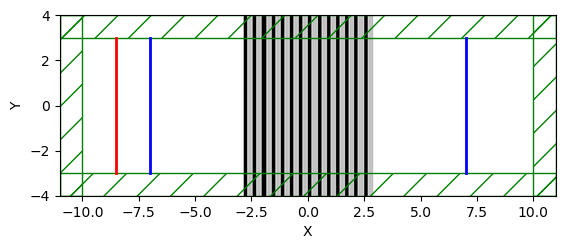

-----------
Initializing structure...
time for choose_chunkdivision = 0.000535965 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (5.74,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.795,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.385,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     blo

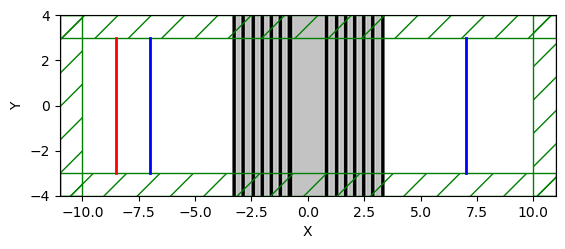

-----------
Initializing structure...
time for choose_chunkdivision = 0.000608921 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (6.72,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.055,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     blo

In [26]:
wl_comparison = []
Ts_comparison = []

resolution = 20
n_1 = 1.5
n_2 = 2.5
layers=14

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

for cavity in [False, True]:
    sim.reset_meep()
    geometry = []
    if(cavity):
        geometry = [mp.Block(
                        mp.Vector3(DBL_width, grat_height,0),
                        # mp.Vector3(x_dim, y_dim, 0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), 0):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                            center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                            material = mp.Medium(index=n_2))]
        for ii in range(0, int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]
    else:
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.plot2D()
    plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    
    wl = []
    Ts = []

    for i in range(nfreq):
        wl = np.append(wl, 1/freqs[i])
        Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])

    wl_comparison += [wl]
    Ts_comparison += [Ts]

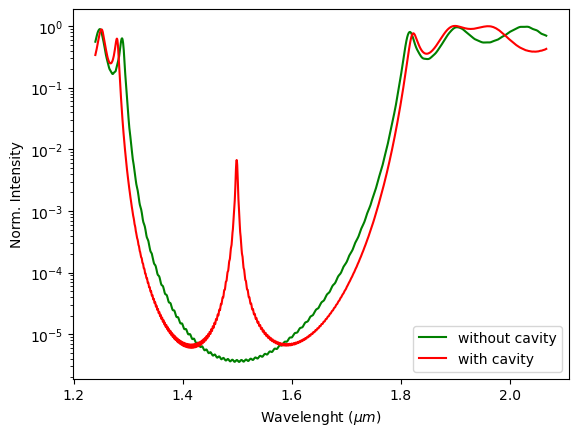

In [27]:
plt.plot(wl_comparison[0], Ts_comparison[0], label='without cavity', color='green')
plt.plot(wl_comparison[1], Ts_comparison[1], label='with cavity', color='red')

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity')

plt.yscale("log")

plt.legend()
plt.show()

## Dependence of the DBR cavity from the index contrast

-----------
Initializing structure...
time for choose_chunkdivision = 0.000401974 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.172556 s
-----------
field decay(t = 50.025000000000006): 0.44974309659639516 / 0.44974309659639516 = 1.0
on time step 3079 (time=76.975), 0.0012992 s/step
field decay(t = 100.05000000000001): 4.599436674321694e-13 / 0.44974309659639516 = 1.0226808836266104e-12
run 0 finished at t = 100.05000000000001 (4002 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.19 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000850916 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = 

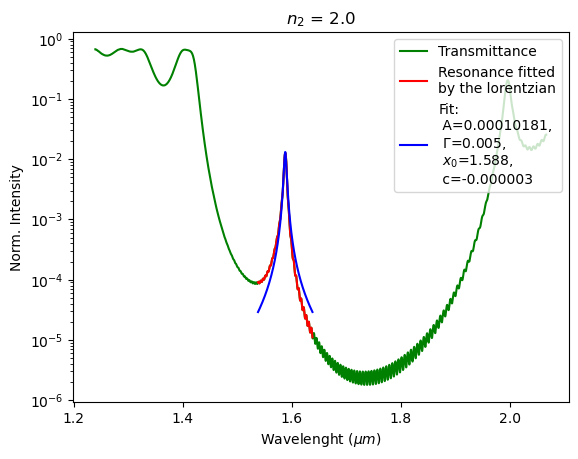

The Q-factor of the cavity is 322.69276180750165
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000540018 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.48,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-3.04,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.6,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

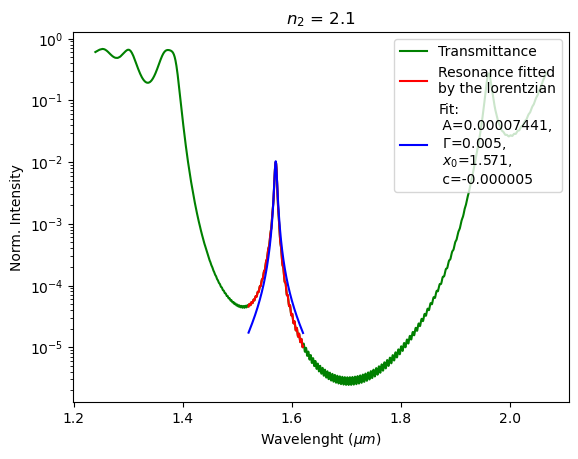

The Q-factor of the cavity is 342.1346208147685
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000756979 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.48,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-3.04,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.6,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = 

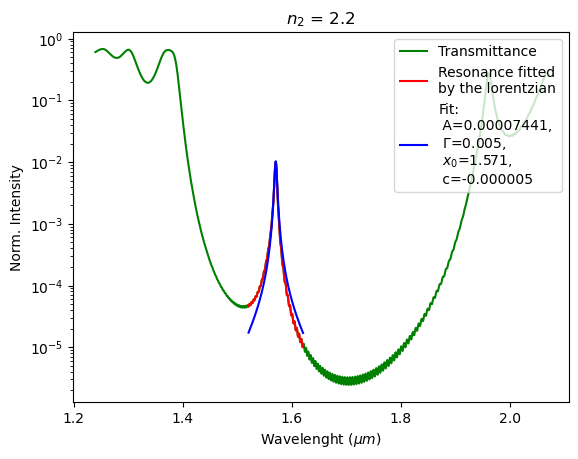

The Q-factor of the cavity is 342.1346208147685
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.17 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000651121 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.415,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.985,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.555,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

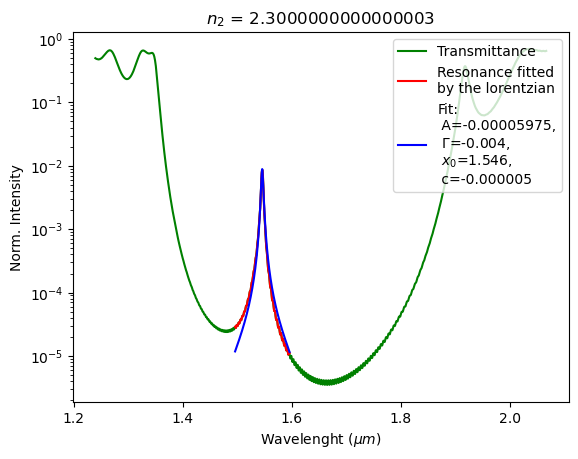

The Q-factor of the cavity is -360.97817112532914
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.16 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000546932 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.35,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.93,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.51,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

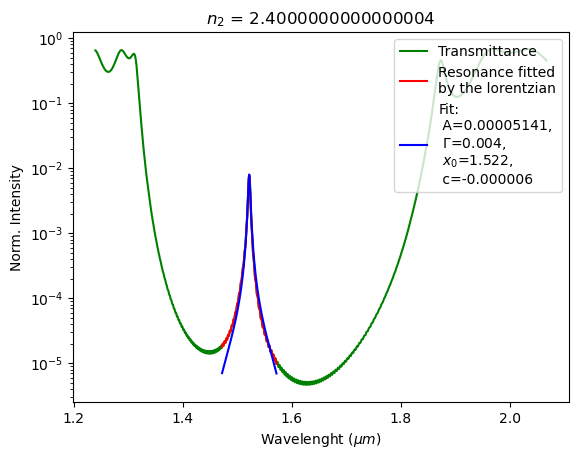

The Q-factor of the cavity is 373.3705553547695
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000538826 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

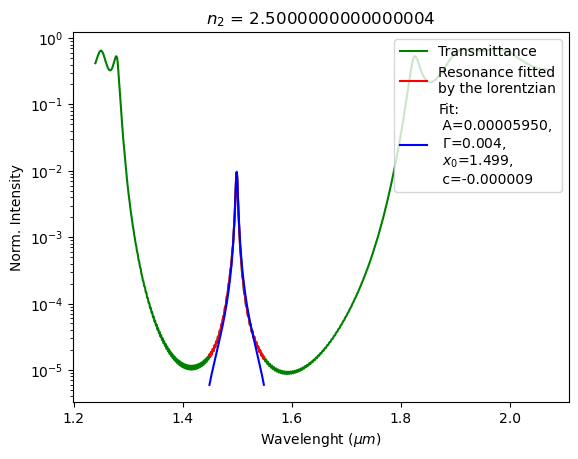

The Q-factor of the cavity is 382.72720779071665
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000660896 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

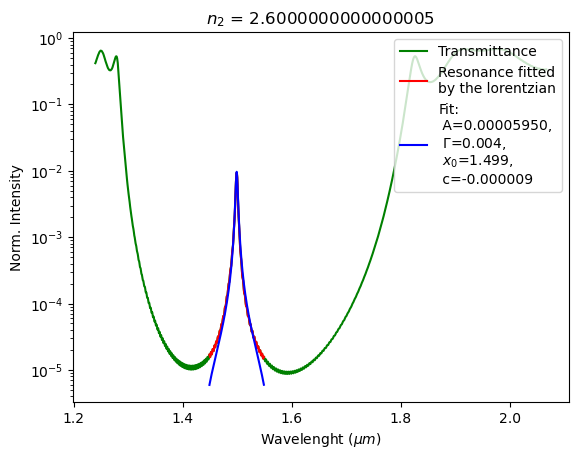

The Q-factor of the cavity is 382.72720779071665
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000689983 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.22,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.82,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.42,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

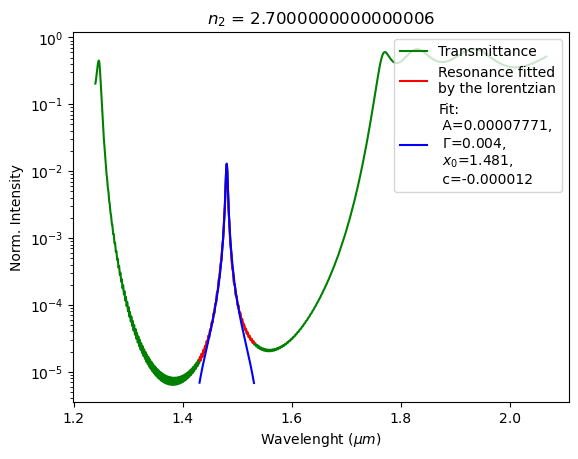

The Q-factor of the cavity is 389.3487167177099
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000571012 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.22,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.82,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.42,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

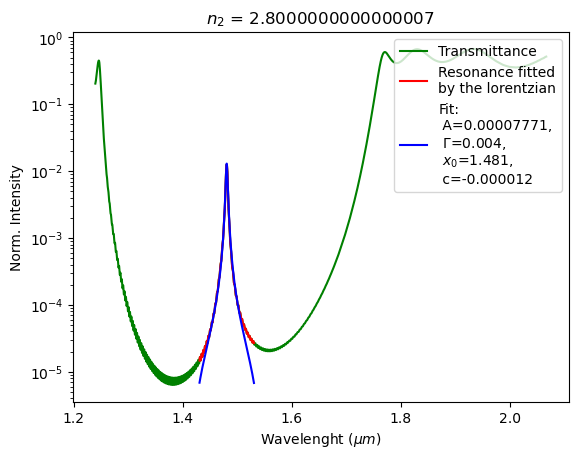

The Q-factor of the cavity is 389.3487167177099
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.13 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000537157 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.155,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.765,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.375,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

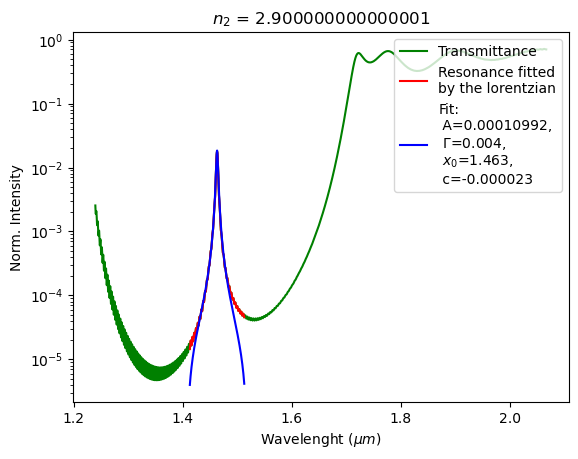

The Q-factor of the cavity is 386.0632234563673


In [28]:
ref_index = []
Q_factor = []

plot=True

resolution = 20
n_1 = 1.5
layers=14

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

for ind in np.arange(2, 3, 0.1):
    grat_period_1 = round(wavelenght / 4 / n_1, 2)
    grat_period_2 = round(wavelenght / 4 / ind, 2)
    DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width
    
    print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
            {grat_period_1} um for the n = {n_1} material
            {grat_period_2} um for the n = {n_2} material\n''')

    sim.reset_meep()
    geometry = [mp.Block(
                    # mp.Vector3(DBL_width, grat_height,0),
                    mp.Vector3(x_dim, y_dim, 0),
                    center = mp.Vector3(0,0,0),
                    material = mp.Medium(index=n_1)),
                ]
    for ii in range(-int(layers/2), 0):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                        center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                        material = mp.Medium(index=n_2))]
    for ii in range(0, int(layers/2)):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                        material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # sim.plot2D()
    # plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    
    wl = []
    Ts = []

    for i in range(nfreq):
        wl = np.append(wl, 1/freqs[i])
        Ts = np.append(Ts, scatt_tran_flux[i]/straight_tran_flux[i])

    peak_T, _ = find_peaks(np.log(Ts), prominence=3)

    wl_low = wl[np.where(wl>=wl[peak_T][0]-0.05)[0]]
    wl_cut = wl_low[np.where(wl_low <= wl[peak_T][0]+0.05)[0]]

    Ts_low = Ts[np.where(wl>=wl[peak_T][0]-0.05)[0]]
    Ts_cut = Ts_low[np.where(wl_low <= wl[peak_T][0]+0.05)[0]]

    popt, _ = curve_fit(fit_lorentzian, wl_cut, Ts_cut, p0=[0.01, 0.05, wl[peak_T][0], 0])

    if (plot):
        plt.plot(wl, Ts, label='Transmittance', color='green')
        plt.plot(wl_cut, Ts_cut, label='Resonance fitted\nby the lorentzian', color='red')
        plt.plot(wl_cut, fit_lorentzian(wl_cut, *popt), color='blue', label='Fit:\n A=%5.8f,\n $\Gamma$=%5.3f,\n $x_0$=%5.3f,\n c=%5.6f' % tuple(popt))

        plt.xlabel('Wavelenght ($\mu m$)')
        plt.ylabel('Norm. Intensity')

        plt.yscale("log")

        plt.title(f'$n_2$ = {ind}')
        plt.legend(loc='upper right')
        plt.show()

    print(f'The Q-factor of the cavity is {popt[2]/popt[1]}')

    ref_index += [ind]
    Q_factor += [popt[2]/popt[1]]

As the contrast between the refractive indexes incresases the two mirrors (DBR) become even more reflective, improving this way the cavity and its quality factor.

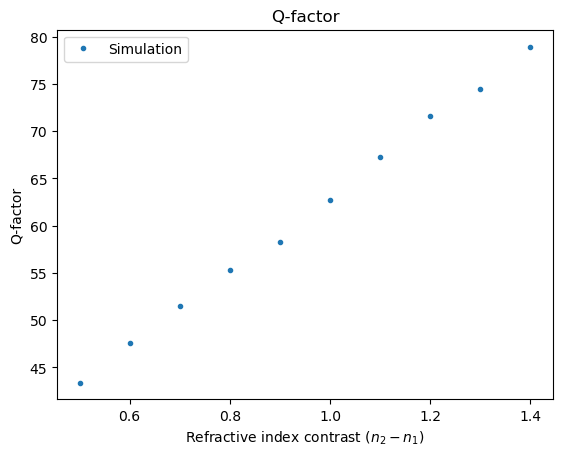

In [30]:
contrast = [ind - n_1 for ind in ref_index]

fig, ax = plt.subplots(1, 1)
ax.plot(contrast, band_width, '.', label='Simulation')

ax.set_title('Q-factor')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Q-factor')

plt.legend()
plt.show()